### Visualizando Filtros Convolucionais

In [1]:
from keras.applications import VGG16
from keras import backend as K
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

model = VGG16(weights ='imagenet',
              include_top = False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [2]:
grads = K.gradients(loss, model.input)[0]

In [3]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [4]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [5]:
# Começando com uma imagem cinza com um pouco de ruido
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

#rodando gradiente ascent por 40 vezes
step = 1
for i in range(40):
    # Computa o valor de perda e o valor do gradiente
    loss_value, grads_value = iterate([input_img_data])
    
    #ajusta a imagem de entrada na direção que maxima a perda
    input_img_data += grads_value * step

In [6]:
# Função que converte o tensor em uma imagem "mostrável"
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [7]:
# Uma função que recebe a camada e o índice do filtro, e retorna uma
# imagem que representa o padrão que maximiza a ativação do filtro.

def generate_pattern(layer_name, filter_index, size = 150):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    
    input_img_data = np.random.random((1, size,size, 3)) * 20 + 128
    
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

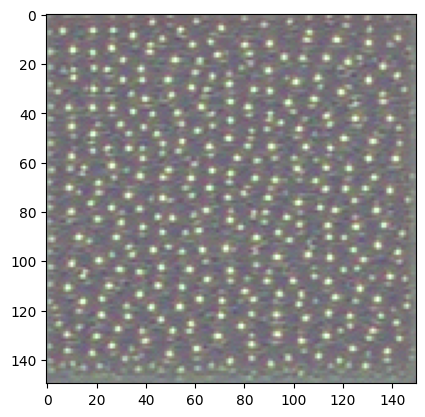

In [23]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))

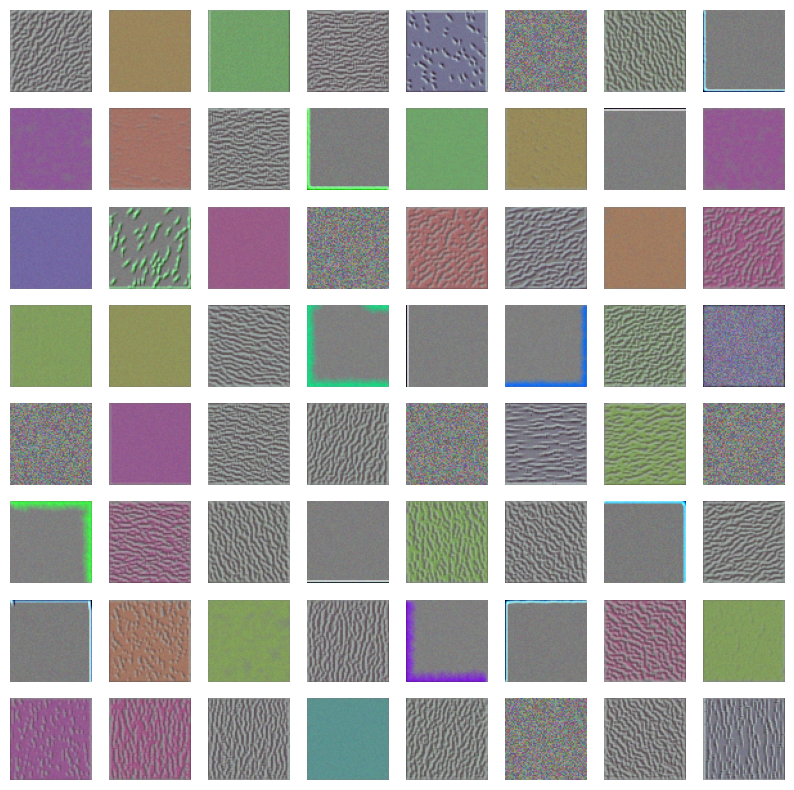

In [28]:
# Todos os filtros de uma camada
layer_name = 'block1_conv1'
size = 64
figure = plt.figure(figsize = (10,10))
cols, rows = 8, 8

for i in range(1, cols * rows + 1):
    img = generate_pattern(layer_name, i-1, size = size)
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze())
    
plt.show()